# Table of Content
[1. Basic Forecasting Workflows](#chapter1)

* [1.1. Basic deployment workflow - batch fitting and forecasting](#11-basic-deployment-workflow---batch-fitting-and-forecasting)

# 1 - Basic Forecasting Workflows

This section explains the basic forecasting workflows, and key interface points for it.

There are four  workflows in sktime.

1. basic deployment workflow: batch fitting and forecasting
2. basic evaluation workflow: evaluating a batch of forecasts against ground truth observations
3. advanced deployment workflow: fitting and rolling updates/forecasts
4. advanced evaluation worfklow: using rolling forecast splits and computing split-wise and aggregate errors, including common back-testing schemes.

Number 1. and 2. will be covered in this tutorial


## 1.1 Data container format

Regardless of workflow, all follow a common input data format. sktime uses `pandas` for representing time series:
 - `pd.Series` for univariate time series and sequences
 - `pd.DataFrame` for multivariate time series and sequences

The `Series.index` and `DataFrame.index` are used for representing the time series or sequence index. `sktime` supports `pandas` integers, periods and `timestamp` indices.



As an example, we will use the Box-Jenkins airline data set, which consists of the number of monthly totals of international airline passengers from 1949 - 1960. Values are in thousands. 

See "Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications", exercises sections 2 and 3.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

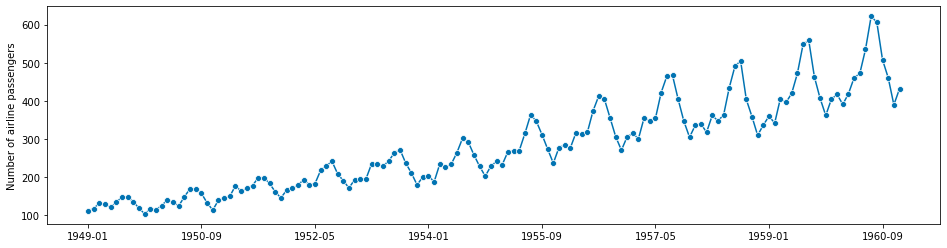

In [3]:
y = load_airline()

# plotting for visualization
plot_series(y)

Generally, sktime expects inputs loaded from a builtin method of `pandas` such as read_csv; other packages that produce `pandas`-compatible inputs are also acceptable. If data is in another format, converting to `pandas`-compatible format is recommended. 

Sometimes data maybe accepted in `pandas`-like format. In such case, `sktime` will try to coerce inputs into `pandas` format and produce `pandas`-style output.

*NOTE:* If your favourite format is not properly read/supported, contribution to further expand `sktime`'s capability is greatly appreciated.

## 1.2 Basic deployment workflow - batch fitting and forecasting
The simplest use case workflow is batch fitting and forecasting. In other words, fitting a model to one batch of past data, then using the model to forecast at point of time in the future.


### 1.2.1 Simple workflow in a nutshell
The steps are as follows:
 1. Preparing data.
 2. Defining horizon, the time points for which forecasts are made. This uses a numpy.array or the ForecastingHorizon object.
 3. Specifying and defining the forecaster. The forecaster follows a scikit-learn-like syntax; forecaster objects follow scikit-learn BaseEstimator interface.
 4. Fitting the forecaster to past data, using the forecaster's fit method.
 5. Making a forecast, using the fitted forecaster.

Basic step-by-step deployment of this workflow is given below. At the end, one-cell workflows are provided as a summary, **with common deviations from the pattern (Sections 1.2.1 and following).**

#### Step 1 - Preparing data.
Input data is assumed to be in `pd.Series` (univariate) or `pd.DataFrame` (multivariate) format. This example utilizes `pd.Series`.

In [4]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

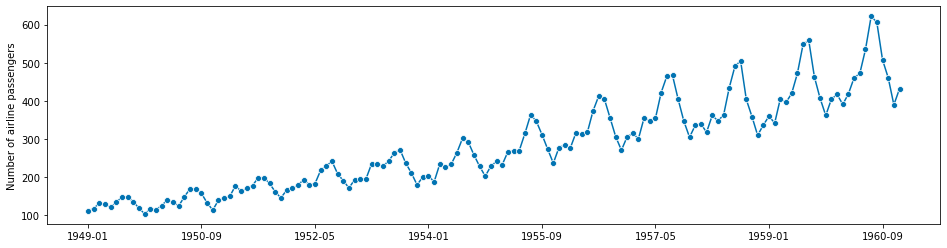

In [5]:
# in the example, we use the airline data set.
y = load_airline()
plot_series(y)

#### Step 2 - Defining horizon.
Next we need to specify the forecasting horizon which will be passed to our forecasting model.

There are two main ways:
 1. Using a `numpy.array` of integers. This assumes either integer index or periodic index (`PeriodIndex`) in the time series; the integer indicates the number of time points or periods ahead we want to make a forecast for. For example, inputting 1 means forecast the next period, 2 the second next period, and so on.
 2. Using a `ForecastingHorizon` object. This can be used to define forecast horizons, using any supported index type as an argument. No periodic index is assumed.
Forecasting horizons can be absolute, referencing specific time points/timestamp in the future, or relative, i.e., referencing time differences to the present. As a default, the present is the latest time point seen in a y-array passed to the forecaster.

`numpy.array`-based forecasting horizons are relative; `ForecastingHorizon` objects can be both relative and absolute. Absolute forecasting horizons can only be specified using `ForecastingHorizon`.


##### 1. Define Horizon using a `numpy` forecasting horizon

In [6]:
import numpy as np
fh = np.arange(1, 37)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

Since the original series' period is 1 month, `fh` will prompt for monthly predictions for the next three years. To predict only the second and fifth month ahead, `fh` can be written as:

In [7]:
import numpy as np
fh = np.array([2, 5])  # 2nd and 5th step ahead

##### 2. Using a `ForecastingHorizon`-based forecasting horizon

The `ForecastingHorizon` object takes absolute indices as input, but it considers the input absolute or relative according to the `is_relative` flag.

`ForecastingHorizon` will automatically assume a relative horizon if temporal difference types from `pandas` are passed; if value types from `pandas` are passed, it will assume an absolute horizon.

**##################################EXAMPLE FOR THIS#############################################**

To define an absolute `ForecastingHorizon` in our example:

In [14]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

`ForecastingHorizon` can be converted from relative to absolute and back via the `to_relative` and `to_absolute` methods. Both of these conversions require a compatible cutoff to be passed:

In [15]:
cutoff = pd.Period("1960-12", freq="M")
fh.to_relative(cutoff)

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

In [16]:
fh.to_absolute(cutoff)

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

#### Step 3 - Specifying and defining the forecaster

To make forecasts, a forecasting algorithm/model needs to be specified. This is done using a `scikit-learn`-like interface. All `sktime` forecasters follow the same interface, so the preceding and remaining steps are the same, regardless of which forecaster is being chosen.

Below, a naive forecaster is chosen to predict the last seen value. **More complex specifications are possible, using pipeline and reduction construction syntax; this will be covered later in Section 2.**

In [17]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")


`NaiveForecaster` has argument `sp` that specifies the seasonal periodicity that the forecaster takes into account. Default is 1 when not specified.

#### Step 4 - Fitting the forecaster to past data
Now the forecaster needs to be fitted to the past data:

In [18]:
forecaster.fit(y)


NaiveForecaster()

#### Step 5 - Making a forecast
We request forecasts for the specified forecasting horizon. This is done after fitting.

In [19]:
y_pred = forecaster.predict(fh)


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

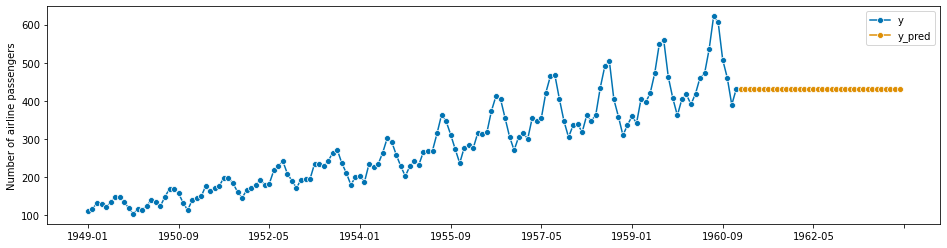

In [20]:
# plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

In summary, we can implement the whole process in the following code cell

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

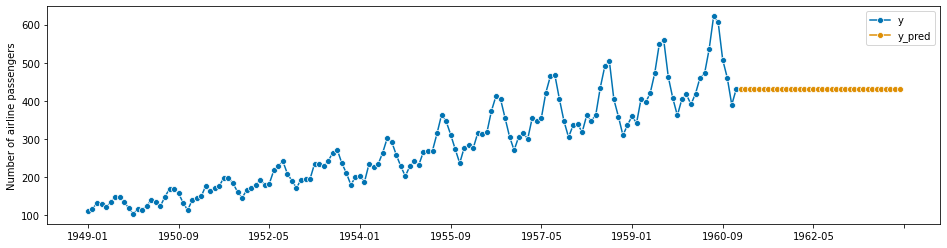

In [21]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=1)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

We can try increasing the period, which is the number of data points in the past that the focaster is repeating (the naive method).


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

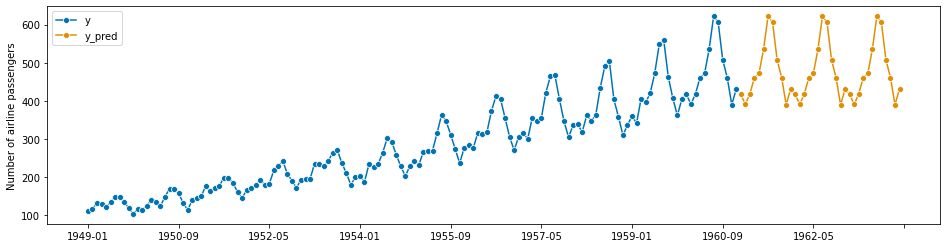

In [23]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["y", "y_pred"])

### 1.2.2 forecasters that require the horizon already in `fit` <a class="anchor" id="section_1_2_2"></a>

Some forecasters need the forecasting horizon to be provided in `fit`. Such forecasters will produce informative error messages when it is not passed in `fit`. 

All forecaster will remember the horizon when it has been passed in `fit` for prediction. The modified workflow to allow for such forecasters is as follows:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

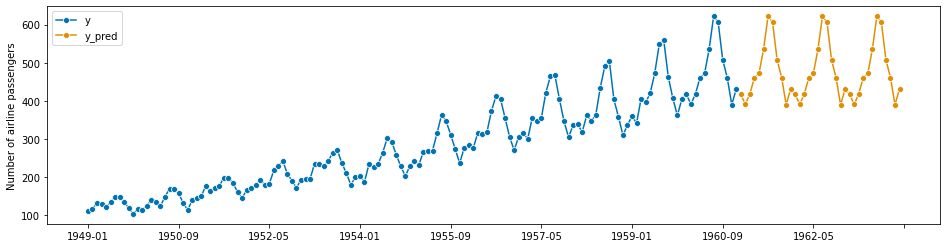

In [24]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict()
plot_series(y, y_pred, labels=["y", "y_pred"])

### 1.2.3 Forecasters that can make use of exogeneous data

Many forecasters can make use of exogeneous time series - other time series that are not forecasted, but are useful for forecasting y. Exogeneous 
time series are always passed as an X argument, in `fit`, `predict`, and other methods (see below). 

Exogeneous time series should always be passed as `pandas.DataFrames`. Most forecasters that can deal with exogeneous time series will assume that the time indices of X passed to `fit` are a super-set of the time indices in y passed to `fit`; and that the time indices of X passed to `predict` are a super-set of time indices in `fh`, although this is not a general interface restriction. Forecasters that do not make use of exogeneous time series still accept the argument (and do not use it internally).

The general workflow for passing exogeneous data is as follows:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

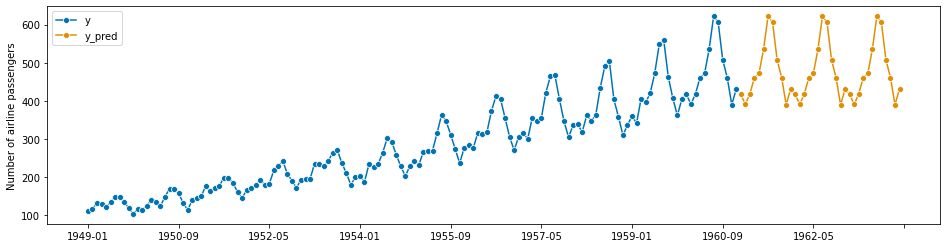

In [25]:
# step 1: data specification
y = load_airline()
# we create some dummy exogeneous data
X = pd.DataFrame(index=y.index)

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, X=X, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict(X=X)
plot_series(y, y_pred, labels=["y", "y_pred"])

NOTE: as in workflows [1.2.1](#121-simple-workflow-in-a-nutshell) and [1.2.2](#122-forecasters-that-require-the-horizon-already-in-fit-a-class"anchor"-id"section122"a), some forecasters that use exogeneous variables may also require the forecasting horizon only in predict. Such forecasters may also be called with [steps 4](#step-4---fitting-the-forecaster-to-past-data) and [step 5](#step-5---making-a-forecast) being


In [26]:

forecaster.fit(y, X=X)
y_pred = forecaster.predict(fh=fh, X=X)

### 1.2.4 Prediction intervals/Confidence intervals
`sktime` provides a unified interface to return prediction interval when forecasting. This is possible directly in the `predict` function, by setting the `return_pred_int` argument to `True`. The `predict` method then returns a second argument. Not all forecasters are capable of returning prediction intervals, in which case an error will be raised.

Obtaining prediction intervals can be done as part of any workflow involving `predict`, by adding the argument `return_pred_int` - below, we illustrate this by modifying the basic workflow in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting):

In [27]:
from sktime.forecasting.theta import ThetaForecaster
# simple workflow
y = load_airline()
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y)

# setting return_pred_int argument to True; alpha determines percentiles
#  intervals are lower = alpha/2-percentile, upper = (1-alpha/2)-percentile
alpha = 0.05  # 2.5%/97.5% prediction intervals
y_pred, y_pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

y_pred_ints is a `pandas.DataFrame` with columns `lower` and `upper`, and rows the indices for which forecasts were made (same as in `y_pred`). Entries are lower/upper (as column name) bound of the nominal alpha predictive interval for the index in the same row.

In [28]:
y_pred_ints

,lower,upper
1961-01,440.404172,442.157901
1961-02,428.509834,430.594102
1961-03,489.853741,492.222872
1961-04,475.682641,478.305882
1961-05,479.539843,482.394664
1961-06,545.302288,548.371264
1961-07,602.738297,606.007428
1961-08,600.983983,604.441704
1961-09,523.534633,527.171176
1961-10,455.941736,459.748710


#### Plotting the predictive interval forecasts
Ideally, this should be turned into a one-liner by moving this code to `utils.plotting` - Contributions in this utility is appreciated.

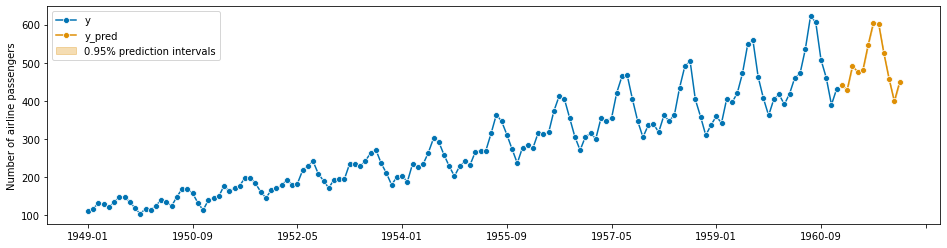

In [29]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=.3,  # opacity of the interval
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## 1.3 Basic evaluation workflow - evaluating a batch of forecasts against ground truth observations
It is a good practice to evaluate statistical performance of a forecaster before deploying it and regularly re-evaluate its performance during and after deployment. The evaluation workflow for the basic batch forecasting task, shown in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting), compares batch forecasts to actual data (test dataset). This is sometimes called (batch-wise) backtesting.

The evaluation workflow is as follows:

1. Splitting historical series into temporal training and test set. The test set should be temporally in the future of the training set.
2. Obtaining batch forecasts, as shown in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting), by fitting a forecaster to the training set and making predictions over the forecasting horizon `fh`.
3. Specifying a performance metric to compare the test set against predictions.
4. Calculating the performance metric of the test set.
5. Testing whether this performance is statistically better than a chosen baseline performance.

*NOTE*: Step 5 (testing) is currently not supported in `sktime`, but is on the development roadmap. For the time being, it is recommended to use custom implementations of appropriate methods (e.g., Diebold-Mariano test; stationary confidence intervals).

*Disclosure*: This evaluation set-up determines how well a given algorithm would have performed on past data. Results are only insofar representative as future performance can be assumed to reflect past performance.This assumption is, in general, false but can be argued under certain assumptions (e.g., stationarity). Monitoring forecasting performance is therefore advised in case an algorithm is applied multiple times.


 training and test set. The test set should be temporally in the future of the training set.
2. Obtaining batch forecasts, as shown in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting), by fitting a forecaster to the training set and making predictions over the forecasting horizon `fh`.
3. Specifying a performance metric to compare the test set against predictions.
4. Calculating the performance metric of the test set.
5. Testing whether this performance is statistically better than a chosen baseline performance.

*NOTE*: Step 5 (testing) is currently not supported in `sktime`, but is on the development roadmap. For the time being, it is recommended to use custom implementations of appropriate methods (e.g., Diebold-Mariano test; stationary confidence intervals).

*Disclosure*: This evaluation set-up determines how well a given algorithm would have performed on past data. Results are only insofar representative as future performance can be assumed to reflect past performance.This assumption is, in general, false but can be argued under certain assumptions (e.g., stationarity). Monitoring forecasting performance is therefore advised in case an algorithm is applied multiple times.



*Example*: In the example, we will use the same airline data previously used in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting). But, instead of predicting the next 3 years, we split the last 3 years of the airline data (`y_test`), and see how the forecaster would have performed three years ago. In other words, when asked to forecast the most recent 3 years (`y_pred`), we assign the last 3 years of data to be `y_test`; any data before this period is assigned to `y_train`.

To evaluate `y_pred`, a quantitative performance metric was used. There are many methods, but `mean_absolute_percentage_error` is chosen in this example. Again, whether `y_preds` values are valid depends on statistical assumptions and data properties, but in general, future prediction should be taken with caution - past performance is not indicative of future performance.

#### Step 1 - splitting a historical data set in to a temporal train and test batch

108 36


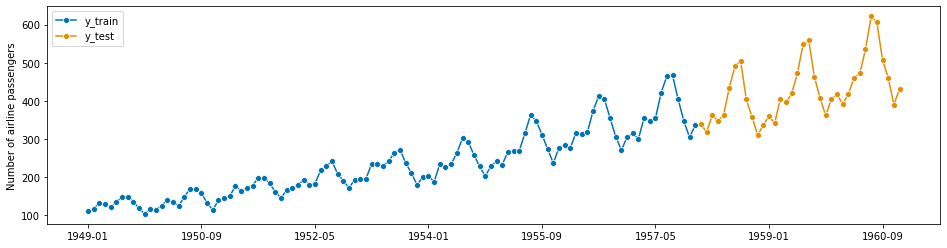

In [30]:
from sktime.forecasting.model_selection import temporal_train_test_split
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

#### Step 2 - Predicting y_pred from y_train
Repeating the workflow in [Section 1.2](#12-basic-deployment-workflow---batch-fitting-and-forecasting), we use `y_train` to predict the values of `y_test`. We call the predictions `y_pred`.

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

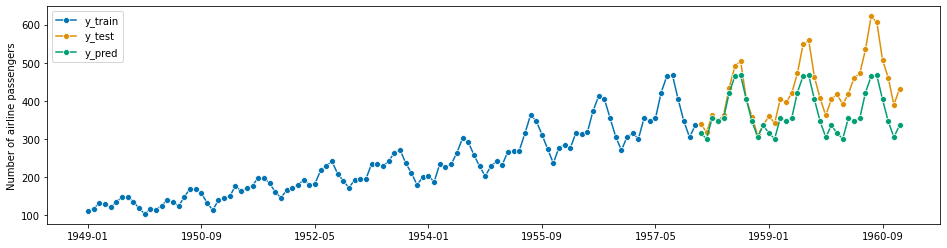

In [31]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

### Steps 3 and 4 - Specifying and calculating a forecasting metric
To evaluate `y_pred`, a forecasting metric is needed. In `sktime`, the functions calculating the metrics return a number when input with prediction and actual series. They are different from `sklearn` metrics in that they accept series with indices rather than `np.arrays`. Forecasting metrics can be invoked in two ways:

* Using the lean function interface, e.g., `mean_absolute_percentage_error` which is a python function `(y_true : pd.Series, y_pred : pd.Series) -> float`
* Using the composable class interface, e.g., `MeanAbsolutePercentageError`, which is a python class, callable with the same signature
Casual users may opt to use the function interface. The class interface supports advanced use cases, such as parameter modification, custom metric composition, tuning over metric parameters (not covered in this tutorial)

In [32]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.145427686270316

Mean Absolute Percentage Error calculates the average absolute percent error. Thus, the lower the value, the better.

In [33]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
# option 2: using the composable class interface
mape = MeanAbsolutePercentageError(symmetric=False)
# the class interface allows us to easily construct variants of the MAPE
#  e.g., the non-symmetric verion
# it also allows for inspection of metric properties
#  e.g., are higher values better (answer: no)?
mape.greater_is_better

False

In [34]:
# evaluation works exactly like in option 2, but with the instantiated object
mape(y_test, y_pred)

0.13189432350948402

*NOTE*: some metrics, such as `mean_absolute_scaled_error`, also require the training set for evaluation. In this case, the training set should be passed as a y_train argument. Refer to the API reference on individual metrics.

*NOTE*: the workflow is the same for forecasters that make use of exogeneous data - no X is passed to the metrics.

### Step 5 - Testing performance against benchmarks
In general, forecast performances should be quantitatively tested against benchmark performances.

Currently (sktime v0.9x), this is a roadmap development item. Contributions are very welcome.


All the steps above can be summarized briefly as below

#### 1. the basic batch forecast evaluation workflow in a nutshell - Evaluated with function metric interface

In [35]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [36]:
# step 1: splitting historical data
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric and
# step 4: computing the forecast performance
mean_absolute_percentage_error(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

0.145427686270316

#### 2 - The basic batch forecast evaluation workflow in a nutshell - Evaluated with metric class interface

In [38]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [39]:
# step 1: splitting historical data
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=True)
# if function interface is used, just use the function directly in step 4

# step 4: computing the forecast performance
mape(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

0.145427686270316

1.4 advanced deployment workflow: rolling updates & forecasts
A common use case requires the forecaster to regularly update with new data and make forecasts on a rolling basis. This is especially useful if the same kind of forecast has to be made at regular time points, e.g., daily or weekly. sktime forecasters support this type of deployment workflow via the update and update_predict methods.

1.4.1 updating a forecaster with the update method
The update method can be called when a forecaster is already fitted, to ingest new data and make updated forecasts - this is referred to as an "update step".

After the update, the forecaster's internal "now" state (the cutoff) is set to the latest time stamp seen in the update batch (assumed to be later than previously seen data).

The general pattern is as follows:

1 - specify a forecasting strategy
2 - specify a relative forecasting horizon
3 - fit the forecaster to an initial batch of data using fit
4 - make forecasts for the relative forecasting horizon, using predict
5 - obtain new data; use update to ingest new data
6 - make forecasts using predict for the updated data
7 - repeat 5 and 6 as often as required


Example: suppose that, in the airline example, we want to make forecasts a year ahead, but every month, starting December 1957. The first few months, forecasts would be made as follows:

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series


In [ ]:
# we prepare the full data set for convenience
# note that in the scenario we will "know" only part of this at certain time points
y = load_airline()

In [ ]:
# December 1957

# this is the data known in December 1975
y_1957Dec = y[:-36]

# step 1: specifying the forecasting strategy
# Set auto = True to enable automatic model selection
# Set n_jbs = -1 to use all processors to run the job
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)

# step 3: this is the first time we use the model, so we fit it
forecaster.fit(y_1957Dec)

# step 4: obtaining the first batch of forecasts for Jan 1958 - Dec 1958
y_pred_1957Dec = forecaster.predict(fh)

In [ ]:
# plotting predictions and past data
plot_series(y_1957Dec, y_pred_1957Dec, labels=["y_1957Dec", "y_pred_1957Dec"])

In [ ]:
# January 1958

# new data is observed:
y_1958Jan = y[[-36]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Jan)

# step 6: making forecasts with the updated data
y_pred_1958Jan = forecaster.predict(fh)

In [ ]:
# note that the fh is relative, so forecasts are automatically for 1 month later
#  i.e., from Feb 1958 to Jan 1959
y_pred_1958Jan

In [ ]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan"],
)

In [ ]:
# February 1958

# new data is observed:
y_1958Feb = y[[-35]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Feb)

# step 6: making forecasts with the updated data
y_pred_1958Feb = forecaster.predict(fh)

In [ ]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb"],
)

A shorthand for running first update and then predict is update_predict_single - for some algorithms, this may be more efficient than the separate calls to update and predict:

In [ ]:
# March 1958

# new data is observed:
y_1958Mar = y[[-34]]

# step 5&6: update/predict in one step
y_pred_1958Mar = forecaster.update_predict_single(y_1958Mar, fh=fh)

In [ ]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    y_pred_1958Mar,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb", "y_pred_1958Mar"],
)

1.4.2 moving the "now" state without updating the model
In the rolling deployment mode, may be useful to move the estimator's "now" state (the cutoff) to later, for example if no new data was observed, but time has progressed; or, if computations take too long, and forecasts have to be queried.

The update interface provides an option for this, via the update_params argument of update and other update funtions.

If update_params is set to False, no model update computations are performed; only data is stored, and the internal "now" state (the cutoff) is set to the most recent date.

In [ ]:
# April 1958

# new data is observed:
y_1958Apr = y[[-33]]

# step 5: perform an update without re-computing the model parameters
forecaster.update(y_1958Apr, update_params=False)

1.4.3 walk-forward predictions on a batch of data
sktime can also simulate the update/predict deployment mode with a full batch of data.

This is not useful in deployment, as it requires all data to be available in advance; however, it is useful in playback, such as for simulations or model evaluation.

The update/predict playback mode can be called using update_predict and a re-sampling constructor which encodes the precise walk-forward scheme.

In [ ]:
# from sktime.datasets import load_airline
# from sktime.forecasting.ets import AutoETS
# from sktime.forecasting.model_selection import ExpandingWindowSplitter
# from sktime.utils.plotting import plot_series

NOTE: commented out - this part of the interface is currently undergoing a re-work. Contributions and PR are appreciated.


In [ ]:
# for playback, the full data needs to be loaded in advance
# y = load_airline()

In [ ]:
# step 1: specifying the forecasting strategy
# forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon
# fh = np.arange(1, 13)

# step 3: specifying the cross-validation scheme
# cv = ExpandingWindowSplitter()

# step 4: fitting the forecaster - fh should be passed here
# forecaster.fit(y[:-36], fh=fh)

# step 5: rollback
# y_preds = forecaster.update_predict(y, cv)

1.5 advanced evaluation worfklow: rolling re-sampling and aggregate errors, rolling back-testing
To evaluate forecasters with respect to their performance in rolling forecasting, the forecaster needs to be tested in a set-up mimicking rolling forecasting, usually on past data. Note that the batch back-testing as in Section 1.3 would not be an appropriate evaluation set-up for rolling deployment, as that tests only a single forecast batch.

The advanced evaluation workflow can be carried out using the evaluate benchmarking function. evaluate takes as arguments:

a forecaster to be evaluated
a scikit-learn re-sampling strategy for temporal splitting (cv below), e.g., ExpandingWindowSplitter or SlidingWindowSplitter
a strategy (string): whether the forecaster should be always be refitted or just fitted once and then updated

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

In [ ]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

todo: performance metrics, averages, and testing - contributions to sktime and the tutorial are welcome.

